# DAML notes
## 8. Classification and Regression trees (CARTs)

<hr style="border:2px solid black"> </hr>


In [1]:
# RUN THIS CELL FIRST

# imports
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from matplotlib.colors import ListedColormap

# Sklearn imports
from sklearn.tree import (
    DecisionTreeClassifier,
    DecisionTreeRegressor,
    plot_tree,
    export_graphviz,
)
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier

# This makes matplotlib output nice figures without much tweaking
plt.rcParams.update(
    {
        "lines.markersize": 10,  # Big points
        "font.size": 15,  # Larger font
        "xtick.major.size": 5.0,  # Bigger xticks
        "ytick.major.size": 5.0,  # Bigger yticks
    }
)

### 8.1 Non-parametric models

The linear models we have considered thus far are parametric. They have a fixed set of parameters which effectively means they have a fixed capacity. The number of parameters doesn't scale with the number of data points. $k$-nearest neighbours which we saw last week is an example of a non-parametric model.  Intuitively, its decision boundary gets more complicated the more data points there are; it is a model whose capacity scales with the number of data points.

Another family of non-parametric models are classification and regression trees (CARTs) which are also known as **decision trees**. They are worth being aware of because they tend to be the state-of-the-art on tabular datasets, beating deep neural networks most of the time. While tabular datasets are arguably less exciting than datasets of text or images, they do make up a lot of the world's data. Think how many Excel spreadsheets that you have come across in your life so far!


### 8.2 Classification trees



These look like upside down trees, and are best understood visually. First, let's generate and plot some training data for a multiclass problem.

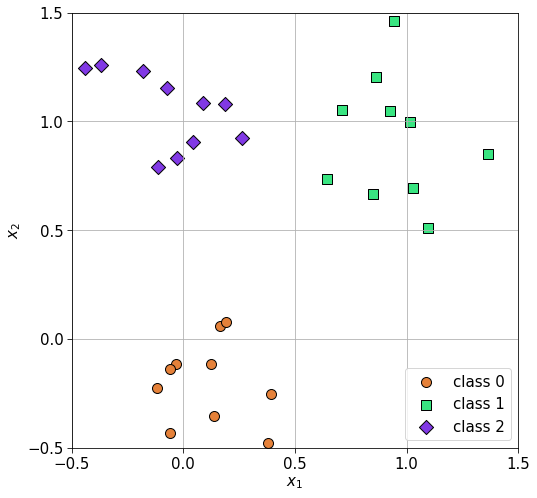

In [2]:
np.random.seed(42)
x0 = np.vstack(
    (np.random.normal(0, 0.25, size=10), np.random.normal(0, 0.25, size=10))
).T
x1 = np.vstack(
    (np.random.normal(1, 0.25, size=10), np.random.normal(1, 0.25, size=10))
).T
x2 = np.vstack(
    (np.random.normal(0, 0.25, size=10), np.random.normal(1, 0.25, size=10))
).T

X = np.vstack((x0, x1, x2))
y = np.hstack((0 * np.ones(10), 1 * np.ones(10), 2 * np.ones(10)))

fig, ax = plt.subplots(figsize=[8, 8])

colours = ["#e58139", "#39e581", "#8139e5"]

ax.scatter(X[y == 0, 0], X[y == 0, 1], color=colours[0], edgecolor="k")
ax.scatter(X[y == 1, 0], X[y == 1, 1], color=colours[1], marker="s", edgecolor="k")
ax.scatter(X[y == 2, 0], X[y == 2, 1], color=colours[2], marker="D", edgecolor="k")
ax.grid()

ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_yticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([-0.5, 1.5])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
plt.legend(["class 0", "class 1", "class 2"], loc="lower right")

Now let's train and visualise a classification tree on this data.

[Text(0.4, 0.8333333333333334, 'X[1] <= 0.294\ngini = 0.667\nsamples = 30\nvalue = [10, 10, 10]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 10\nvalue = [10, 0, 0]'),
 Text(0.6, 0.5, 'X[0] <= 0.454\ngini = 0.5\nsamples = 20\nvalue = [0, 10, 10]'),
 Text(0.4, 0.16666666666666666, 'gini = 0.0\nsamples = 10\nvalue = [0, 0, 10]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 10\nvalue = [0, 10, 0]')]

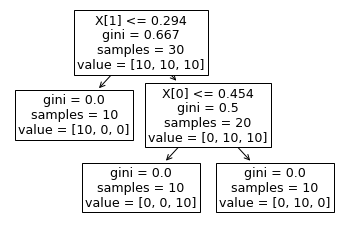

In [3]:
model = DecisionTreeClassifier().fit(X, y)

plot_tree(model)

This is the barebones way to visualise the tree. We can do it in a snazzier manner using graphviz.

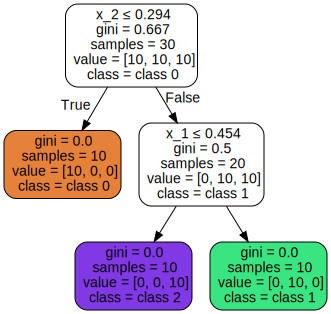

In [4]:
dot_data = export_graphviz(
    model,
    out_file=None,
    feature_names=["x_1", "x_2"],
    class_names=["class 0", "class 1", "class 2"],
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph

Each box is a **node**. The training data comes into the top node (the root node). The `value` field tells us the distribution of class labels for the data coming into that node. It is $[10,10,10]$ for the root node as this is the distribution of the whole training set. 

The training data is split according to some criterion. For the first node, this is whether $x_2$ i.e. the value of the second feature is less than or equal to $0.294$. By looking at the two *child* nodes of this root node, we can see that 10 examples, all of which are labelled as class 0, fall into the left child node and 20 examples (10 of which are class 1, 10 of which are class 2) fall into the right child node.

**At test time a point proceeds down the tree and is then classified according to the majority class in the corresponding split of training data at that node.**

We can look at the decision boundary for the tree to get a feel for what it does in feature space.

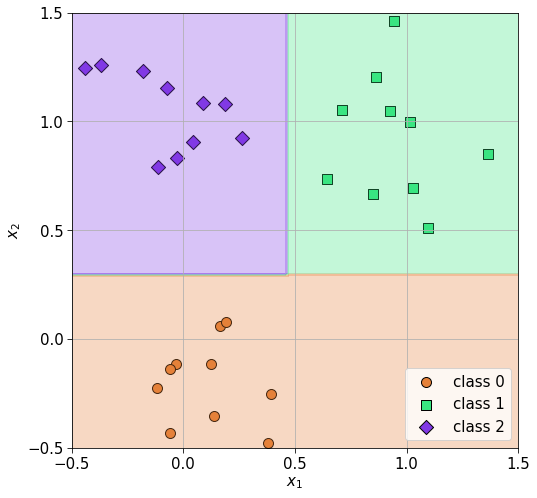

In [5]:
fig, ax = plt.subplots(figsize=[8, 8])

ax.scatter(X[y == 0, 0], X[y == 0, 1], color="#e58139", edgecolor="k")
ax.scatter(X[y == 1, 0], X[y == 1, 1], color="#39e581", marker="s", edgecolor="k")
ax.scatter(X[y == 2, 0], X[y == 2, 1], color="#8139e5", marker="D", edgecolor="k")
ax.grid()

ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_yticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([-0.5, 1.5])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
plt.legend(["class 0", "class 1", "class 2"], loc="lower right")

# Add the decision boundary
disp = DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    response_method="predict",
    alpha=0.3,
    grid_resolution=200,
    ax=ax,
    cmap=ListedColormap(colours),
)

The decision boundary is non-linear, but consists of a bunch of horizontal and vertical lines! Each node separates data points according to some threshold for one particular feature, and corresponds to one of these lines.

### 8.3 Classification tree learning

We have a training set $\mathfrak{D} =\{(\mathbf{x}^{(n)}, y^{(n)})\in N\}$ where $\mathbf{x}\in\mathbb{R}^D$ and $y \in \mathbb{Z}^+_{<K}$. Classification tree learning consists of creating a node for splitting the dataset into two data splits, and then creating a node that splits each of these data splits in two, and so on. This is done **greedily** in that we optimise for each split without giving any thought as to what will happen at later splits. If we get to a node where the incoming data only has points from a single class, or we reach some kind of stopping criterion (e.g. we're only allowed to go to a certain depth) then the node is converted into a leaf node and no further splitting occurs.




![splits](data/tree-splits.png)

Consider a subset of data arriving at some node $i$: $\mathfrak{D}_i =\{(\mathbf{x}^{(n)}, y^{(n)})\in N_{i}\}$. This will split this subset into

\begin{equation}\mathfrak{D}_i^L =\{(\mathbf{x}^{(n)}, y^{(n)})\in N_{i}:x_j^{(n)}\leq t\}\end{equation}

and

\begin{equation}\mathfrak{D}_i^R =\{(\mathbf{x}^{(n)}, y^{(n)})\in N_{i}:x_j^{(n)}>t\}\end{equation}

Remember we are being greedy. We don't care what happens later on, we just want to find the feature $j$ and the threshold $t$ that give us the best split here.

This is starting to sound like an optimisation problem! In fact, what we want to solve is 

\begin{equation}\underset{j,t}{\mathrm{minimise}}\,\, \, \frac{\vert \mathfrak{D}_i^L(j,t)\vert }{\vert \mathfrak{D}_i\vert} c({D}_i^L(j,t)) + \frac{\vert \mathfrak{D}_i^R(j,t)\vert}{\vert \mathfrak{D}_i\vert} c({D}_i^R(j,t))\end{equation}

This looks intimidating, so let's break it down. $c$ is a function that takes a split and returns a scalar indicating how **bad** that split is. For instance, if $c({D}_i^L(j,t))$ is low then our left split ${D}_i^L(j,t)$ is good. However, we care about how many data items are in the split. If there aren't many then we don't really care about how bad it is, but if there are lots then we really do. This is why the first term above is the (negative) quality of the left split $c({D}_i^L(j,t))$  **weighted** by its relative size $\frac{\vert \mathfrak{D}_i^L(j,t)\vert }{\vert \mathfrak{D}_i\vert} $ to the right split. The second term is the (negative) quality of the right split weighted by its relative size. We want both the left and right splits to be good, but we balance how much we care about the splits according to their size.

But what is a good split for classification? If a split was able to entirely isolate one class from the rest that would be great. In constrast, if a split wasn't able to separate classes out from each other that wouldn't be ideal. We can quantify this by looking at the distribution of class labels after a split. If we normalise this distribution by the number of data points we get an empirical probability distribution (specifically, a categorical distribution).

> **An important point to be aware of, is that a test point is classified at a leaf node according to the highest probability in this distribution.**

Let's consider our original training set, and look at some probability distributions for various splits.

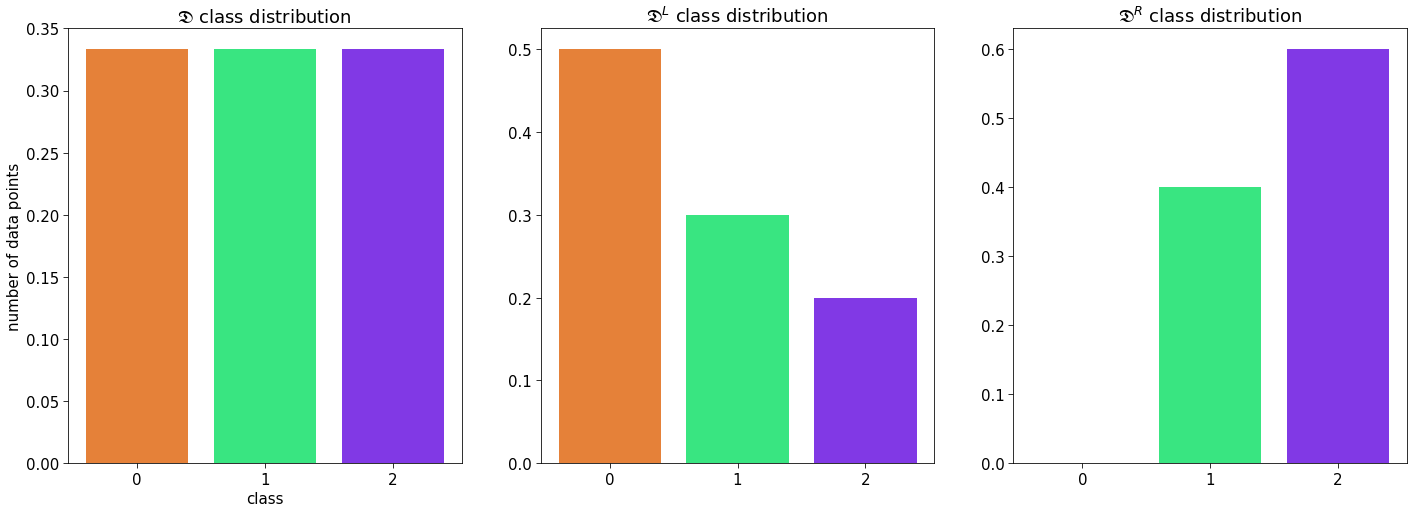

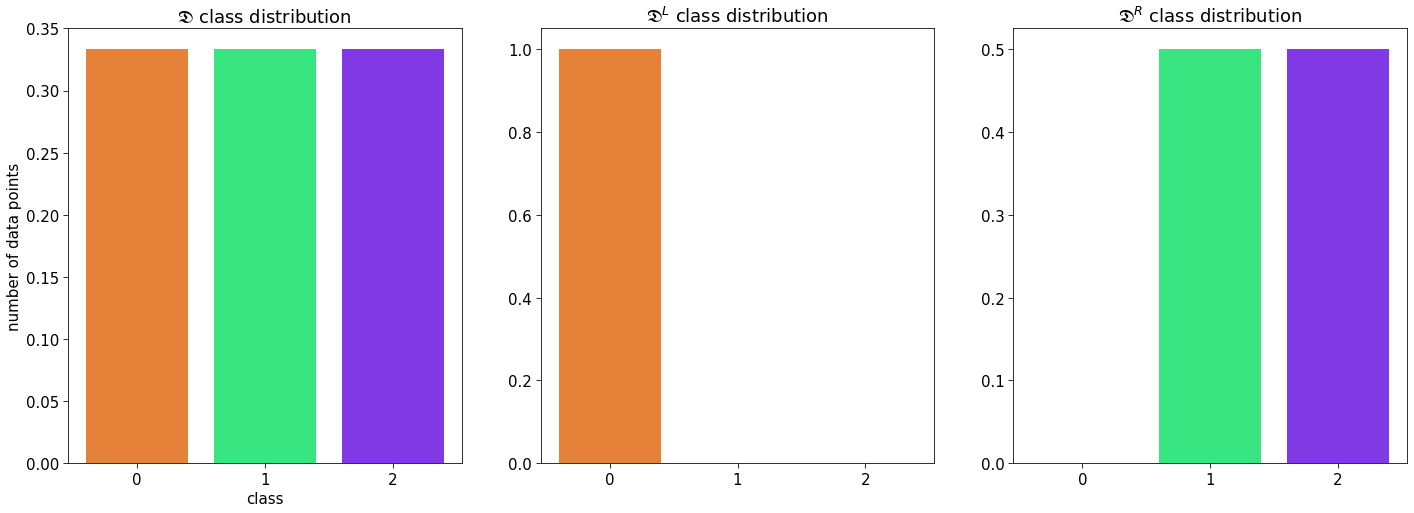

In [6]:
# Bad code alert!


def split(X, y, j, t):
    left = X[:, j] < t
    right = ~left

    X_L, y_L = X[left], y[left]
    X_R, y_R = X[right], y[right]

    return X_L, y_L, X_R, y_R


def plot_split_dists(X, y, j, t):

    _, y_L, _, y_R = split(X, y, j, t)

    fig, axes = plt.subplots(1, 3, figsize=[24, 8])

    axes[0].bar(
        [0, 1, 2],
        [np.sum(y == k) / len(y) for k in range(3)],
        color=["#e58139", "#39e581", "#8139e5"],
    )
    axes[0].set_xticks([0, 1, 2])
    axes[0].set_xlabel("class")
    axes[0].set_ylabel("number of data points")
    axes[0].set_title("$\mathfrak{D}$ class distribution")

    axes[1].bar(
        [0, 1, 2],
        [np.sum(y_L == k) / len(y_L) for k in range(3)],
        color=["#e58139", "#39e581", "#8139e5"],
    )
    axes[1].set_xticks([0, 1, 2])
    axes[1].set_title("$\mathfrak{D}^L$ class distribution")

    axes[2].bar(
        [0, 1, 2],
        [np.sum(y_R == k) / len(y_R) for k in range(3)],
        color=["#e58139", "#39e581", "#8139e5"],
    )
    axes[2].set_xticks([0, 1, 2])
    axes[2].set_title("$\mathfrak{D}^R$ class distribution")


# Split at
plot_split_dists(X, y, 1, 1)
plot_split_dists(X, y, 1, 0.2)

The split corresponding to the bottom row is better as it completely isolates class 0 in the left split. The split correspond to the top row isn't great as the left split still has examples for all the classes.

With this in mind, we can look at the two most common choices for $c$ when it comes to evaluating splits. The first is **entropy**. The entropy of a probability distribution basically tells us how uniform it is.

\begin{equation}H=-\sum_{k} p_k \log_2  p_k\end{equation} 

The second is **Gini impurity**. This is the probability of incorrectly classifying a random point in a split according to the probability distribution of that split.

\begin{equation}G=-\sum_{k} p_k(1-p_k)\end{equation} 


These perform similarly, and Gini impurity is cheaper to compute so we will use that by default. Let's edit our code above to compute the quantity we want to minimise for both the splits i.e. $\frac{\vert \mathfrak{D}_i^L(j,t)\vert }{\vert \mathfrak{D}_i\vert} c({D}_i^L(j,t)) + \frac{\vert \mathfrak{D}_i^R(j,t)\vert}{\vert \mathfrak{D}_i\vert} c({D}_i^R(j,t))$ where $c$ is Gini Impurity.

In [7]:
def gini(y):
    p = np.array([np.sum(y == k) / len(y) for k in range(3)])
    return p.T @ (1 - p)


def score_split(X, y, j, t):
    left = X[:, j] < t
    right = ~left

    X_L, y_L = X[left], y[left]

    X_R, y_R = X[right], y[right]

    loss = (len(y_L) / len(y)) * gini(y_L) + (len(y_R) / len(y)) * gini(y_R)
    return loss


print(f"Loss for splitting with j=1 and t=1.0 is {score_split(X, y, 1, 1)}")
print(f"Loss for splitting with j=1 and t=0.2 is {score_split(X, y, 1, 0.2)}")

Loss for splitting with j=1 and t=1.0 is 0.5733333333333333
Loss for splitting with j=1 and t=0.2 is 0.3333333333333333


Clearly, the second split is better. Solving this optimisation problem can simply be done by considering each feature, and then using each of the unique values of that feature in the split as a possible threshold (but sklearn does all this for us).

### 8.4 Regression trees


We now have a training set $\mathfrak{D} =\{(\mathbf{x}^{(n)}, y^{(n)})\in N\}$ where $\mathbf{x}\in\mathbb{R}^D$ and $y \in \mathbb{R}$. $y$ is now a target for regression instead of a class label. 


Regression trees are a lot like classification trees except each node is associated with a scalar quantity (target) rather than a distribution over classes. Specifically, this quantity is the mean target  of all the data points in the split $\hat{y}$. 

Additionally, the $c$ used in the objective for splitting is different. It is usually **mean squared error**. At each node we still solve 

\begin{equation}\underset{j,t}{\mathrm{minimise}}\,\, \, \frac{\vert \mathfrak{D}_i^L(j,t)\vert }{\vert \mathfrak{D}_i\vert} c({D}_i^L(j,t)) + \frac{\vert \mathfrak{D}_i^R(j,t)\vert}{\vert \mathfrak{D}_i\vert} c({D}_i^R(j,t))\end{equation}

but with 

\begin{equation}c(\mathfrak{D}_i) = \frac{1}{\vert \mathfrak{D}_i\vert }\sum_{n\in \mathfrak{D}_i}(y^{(n)}-\bar {y}) ^2\end{equation} 

where $\bar{y}$ is the mean target of the data points in the split.

When a test point goes into the tree we predict its target as being the value associated with the leaf node it ends up at.

Let's look at a simple 1D example. We will fit a regression tree (curtailed to maximum depth of 2 for simplicity), plot its predictions alongside the training data, and visualise the tree structure. Bear in mind that as this is 1D there is only 1 feature (so $j=0$ for all splits).

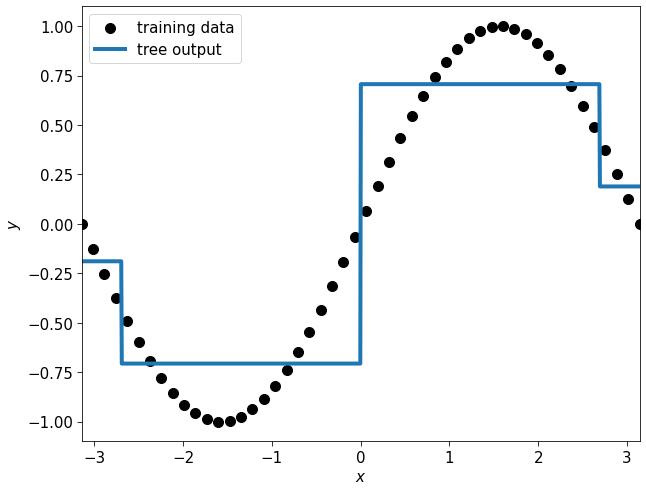

In [8]:
fig, ax = plt.subplots(figsize=[10, 8])

x = np.linspace(-np.pi, np.pi, 50)
y = np.sin(x)
ax.set_xlim([-np.pi, np.pi])
ax.scatter(x, y, color="k")


X = x.reshape(-1, 1)
model = DecisionTreeRegressor(max_depth=2).fit(X, y)

x_dummy = np.linspace(-np.pi, np.pi, 1000)
y_hat = model.predict(x_dummy.reshape(-1, 1))

ax.plot(x_dummy, y_hat, linewidth=4)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

plt.legend(["training data", "tree output"])

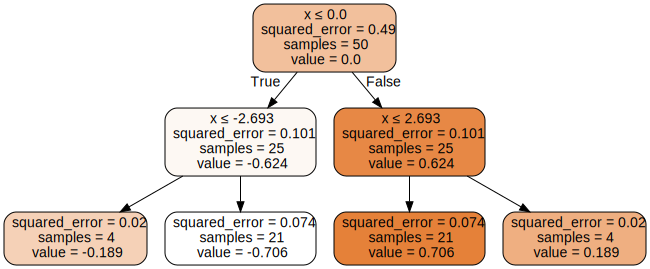

In [9]:
dot_data = export_graphviz(
    model,
    out_file=None,
    feature_names=["x"],
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph

Make sure that you are happy that the four leaf nodes of this tree correspond to the four horizontal lines in the plot.

### 8.5 Ensembles

Decision trees are extremely susceptible to overfitting, and in practice aren't that useful on their own. However, as part of an ensemble they can be very powerful. Random forests and (ensembles of) gradient boosted decision trees both excel on tabular data. **We can have ensembles of other model types but trees tend to excel in ensembles!**

Ensembles are when we have multiple models $f_0(\mathbf{x}),f_1(\mathbf{x}),f_2(\mathbf{x}),\dots$ and we make predictions using some combination of their outputs. This is usually the mean:

\begin{equation}f(\mathbf{x}) = \frac{1}{T}\sum_{t} f_t(\mathbf{x})\end{equation}

Intuitively, you can think of this as being the "wisdom of the crowd", or more informally, like asking the audience in "Who wants to be a millionaire?". However, tree learning (at least in how it's been presented here) is deterministic, so we would need to introduce some randomness. 

### 8.6 Bagging

In boostrap aggregation, or bagging, the randomness comes from each tree in an ensemble being trained on different versions of the training data. Specifically, each tree is trained on a subset of the training data **sampled with replacement**.

Let's look at an example of a single tree versus bagging on a toy dataset.

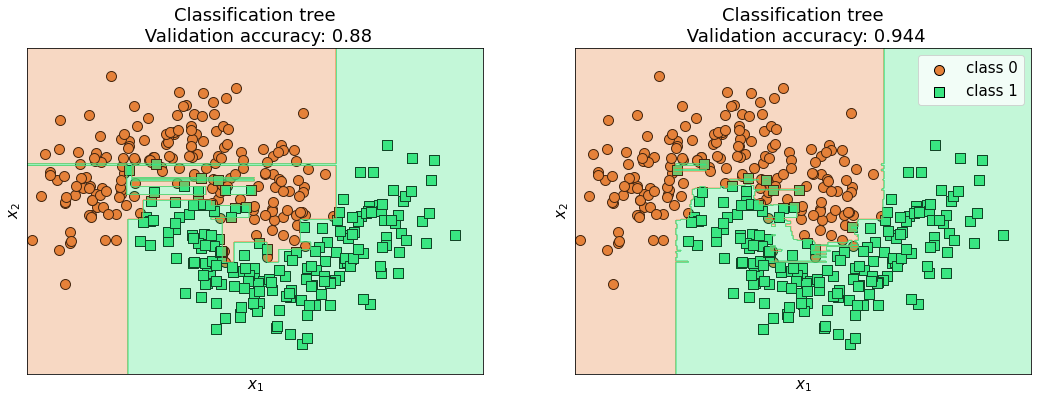

In [10]:
X, y = make_moons(n_samples=500, noise=0.275, random_state=42)
X, X_val, y, y_val = train_test_split(X, y, random_state=42)

fig, axes = plt.subplots(1, 2, figsize=[18, 6])

for i in range(2):

    axes[i].scatter(X[y == 0, 0], X[y == 0, 1], color="#e58139", edgecolor="k")
    axes[i].scatter(
        X[y == 1, 0], X[y == 1, 1], color="#39e581", marker="s", edgecolor="k"
    )
    axes[i].scatter(
        X[y == 2, 0], X[y == 2, 1], color="#8139e5", marker="D", edgecolor="k"
    )
    axes[i].scatter(
        X[y == 3, 0], X[y == 3, 1], color="#399de5", marker="X", edgecolor="k"
    )
    axes[i].set_xlabel("$x_1$")
    axes[i].set_ylabel("$x_2$")
    plt.legend(["class 0", "class 1"], loc="best")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlim([-1.5, 3])
    axes[i].set_ylim([-1.5, 2])

colours = ["#e58139", "#39e581"]

tree = DecisionTreeClassifier().fit(X, y)

axes[0].set_title(
    f"Classification tree\n Validation accuracy: {tree.score(X_val,y_val)}"
)
disp = DecisionBoundaryDisplay.from_estimator(
    tree,
    X,
    response_method="predict",
    alpha=0.3,
    grid_resolution=500,
    cmap=ListedColormap(colours),
    ax=axes[0],
)

bag = BaggingClassifier(n_estimators=50, random_state=63).fit(X, y)

axes[1].set_title(
    f"Classification tree\n Validation accuracy: {bag.score(X_val,y_val)}"
)
disp = DecisionBoundaryDisplay.from_estimator(
    bag,
    X,
    response_method="predict",
    alpha=0.3,
    grid_resolution=500,
    cmap=ListedColormap(colours),
    ax=axes[1],
)

Notice that the bagging ensemble performs better on held-out validation data.

A **Random Forest** is a very popular ensemble model that is identical to a bagging ensemble of trees apart from one difference: at each node during tree learning (for every tree) only a subset of features are made available to find the optimal split. This prevents trees from relying on the same features for learning, and encourages variety.

### 8.7 Gradient Boosting

I did not include gradient boosting in the course last year. It is conceptually a bit tricky at first (or at least, I found it so) but it forms the basis of [XGBoost](https://xgboost.readthedocs.io/en/stable/) which is an extremely popular algorithm famous for winning Kaggle competitions. I therefore felt it was worth including!

First, I'll describe the process of **boosting**. Assume we have a weak learner (read: a rubbish model) $F_0(\mathbf{x})$. This model isn't good and makes lots of mistakes. Now let's introduce another weak learner $F_1(\mathbf{x})$ that tries to fix the mistakes of $F_0(\mathbf{x})$. These can be used in an ensemble $f_1(\mathbf{x})=F_0(\mathbf{x})+F_1(\mathbf{x})$. Now let's introduce yet another weak learner $F_2(\mathbf{x})$ that tries to fix ths mistakes made by this ensemble and so on.

Gradient boosting is basically gradient descent in function space, and adding a weak learner corresponds to taking a negative gradient step.

"What?" would be the correct response to the last statement, so let's take it very slowly.

Let's briefly recap gradient descent with a parametric model $f_{\boldsymbol\theta}(\mathbf{x})$ where $\boldsymbol\theta$ is a vector of the model's parameters (for a linear model this would just be a concatenation of the weight vector and a bias). Our goal is to find the parameters that minimise some loss function $L_{avg}$ (note the unusual subscript) which is an average of individual losses $L^{(n)}$across training examples for those parameters.


\begin{equation} L_{avg}= \frac{1}{N}\sum_{n}L(y^{(n)},\mathbf{x}^{(n)},{\boldsymbol\theta})=  \frac{1}{N}\sum_{n}L^{(n)}
\end{equation}

e.g. for regression, we typically use a mean squared error loss per point $L= (y-f_{\boldsymbol\theta}(\mathbf{x}))^2$.

We first initialise the parameters at random; we will denote these initial parameters as $\boldsymbol\theta_0$. We then compute the gradient $\nabla_{\boldsymbol\theta} L_{avg}(\boldsymbol\theta_0)$ and take a step in the opposite direction in weight space:

\begin{equation}\boldsymbol\theta_1= \boldsymbol\theta_0 - \alpha \nabla_{\boldsymbol\theta} L_{avg}(\boldsymbol\theta_0)\end{equation}

This is done iteratively 

\begin{equation}\boldsymbol\theta_{t+1}= \boldsymbol\theta_t - \alpha \nabla_{\boldsymbol\theta} L_{avg}(\boldsymbol\theta_t)\end{equation}

Now on to gradient boosting. We will start by representing our model as a vector according to its value at the training points.

\begin{equation}\mathbf{f}_t = \begin{bmatrix}
f_t(\mathbf{x}^{(1)})& f_t(\mathbf{x}^{(2)})& \dots&f_t(\mathbf{x}^{(N)}) \end{bmatrix}^\top \end{equation}

This isn't as wacky as it first sounds. If we had points everywhere, then we'd have a very (infinitely!) long vector that perfectly describes the function (model). Notice the subscript $t$: this corresponds to a *time-step* and we will be updating the function in a similar way to how we update the weights in gradient descent.

We can compute the loss for each of our training points (this is a function of our model and class labels) and store these in a vector too:

\begin{equation}
\mathbf{L}(\mathbf{f}_t) = \begin{bmatrix}
L(y^{(1)},f_t(\mathbf{x}^{(1)}))& 
L(y^{(2)},f_t(\mathbf{x}^{(2)}))& 
\dots&
L(y^{(N)},f_t(\mathbf{x}^{(N)}))
 \end{bmatrix}^\top 
\end{equation}

Our loss function $L$ can (usually) be differentiated with respect to $f(\mathbf{x})$. For instance, if $L= (y-f_{\boldsymbol\theta}(\mathbf{x}))^2$ then $\nabla_{f(\mathbf{x})}L= 2(f_{\boldsymbol\theta}(\mathbf{x})- y)$. We can therefore create a vector of **gradients** with respect to $f(\mathbf{x})$.
\begin{equation}\mathbf{g}_t =
\begin{bmatrix}
\nabla_{f_t}L(y^{(1)},f_t(\mathbf{x}^{(1)}))& 
\nabla_{f_t}L(y^{(2)},f_t(\mathbf{x}^{(2)}))& 
\dots&
\nabla_{f_t}L(y^{(N)},f_t(\mathbf{x}^{(N)}))
 \end{bmatrix}^\top  \end{equation}
 
 or concisely,
 
\begin{equation}\mathbf{g}_t=\begin{bmatrix}
g_t^{(1)}&g_t^{(2)}&\dots &g_t^{(N)}
\end{bmatrix}\end{equation}

Gradient descent in function space is then iteratively performing

\begin{equation}\mathbf{f}_{t+1} = \mathbf{f}_t - \alpha \mathbf{g}_t\end{equation}

If you followed all that great, if not, reread it and write it out until you do! 

Gradient tree boosting looks like the above where

1. The function at time step $t$ is an ensemble of regression trees $f_t(\mathbf{x}) = \sum_t F_t (\mathbf{x})$ (even if the problem is classification)

2. The gradient update step is performed by fitting a regression tree to $\{(\mathbf{x}^{(n)}, -g_t^{(n)})\}_{n=1}^{N}$ and adding it to the ensemble

Gradient boosted decision trees can be used straightforwardly in sklearn but you will implement them by hand in the lab!

In [11]:
gb = GradientBoostingClassifier().fit(X, y)
gb.score(X_val, y_val)

0.928

<hr style="border:2px solid black"> </hr>

#### Written by Elliot J. Crowley and &copy; The University of Edinburgh 2022-24